# COGS516 - Assignment 4

Please enter your **name, surname** and **student number** instead of `"NAME-HERE"`, `"SURNAME-HERE"`, `"NUMBER-HERE"` below

In [ ]:
student = {
    'name' : "Abdullah-Burkan" ,
    'surname' : "Bereketoğlu", 
    'studentNumber' : "2355170"
}

print(student)

{'name': 'Abdullah-Burkan', 'surname': 'Bereketoğlu', 'studentNumber': '2355170'}


In [ ]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import daft

The `Recall.csv` dataset is from Oberauer (2019) which investigate the capacity of working memory. In this study, each subject was presented word lists with different lengths (containing 2, 4, 6 and 8 words). Afterwards, they were asked to recall a word given its position in the list. Figure shows an example of set size 4. 

<!-- ![](./fig_memory.png) -->
![fig_memory.png](attachment:fig_memory.png)

The dataset contains the following variables:

- `set_size`: the number of words shown to the subject
- `correct`: 1 if the answer was correct, 0 otherwise
- `tested`: the position of the word asked
- The other variables in the dataset indicates the subject, trial, session and block ids.


> Oberauer, Klaus. 2019. “Working Memory Capacity Limits Memory for Bindings.” Journal of Cognition 2 (1): 40. https://doi.org/10.5334/joc.86

In [ ]:
d = pd.read_csv("Recall.csv")

In [ ]:
d.head()

,subj,set_size,correct,trial,session,block,tested
0,10,4,1,1,1,1,2
1,10,8,0,4,1,1,8
2,10,2,1,9,1,1,2
3,10,6,1,23,1,1,2
4,10,4,1,5,1,2,3


It is known that as the number of items to be held in working memory increase (`set_size` or $S$), the accuracy decraease (`correct` or $C$). The number of items shown ($S$) also affects where the test item will be (`tested` or $T$). Finally, the location of the test item ($T$) can also affect accuracy ($C$) as items that are shown later can be easier to remember. 

1. Draw a DAG for this problem using the `daft` package.

In [ ]:
import networkx as nx

In [ ]:
graph = nx.DiGraph()
graph.add_edges_from([("S","T"),("T","C"),("S","C")])

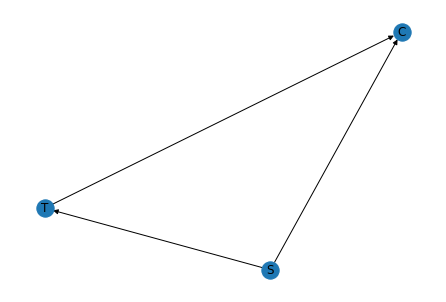

In [ ]:
nx.draw(graph, with_labels=True)

Daft was not working in google colab and Ipython was having problems with Int32 and INT64 so I used colab instead of Jupyter.

1. Estimate the **total effect** of `set_size` on `correct`. Note that, the outcome variable is a categorical 0/1 variable. You should follow the Bayesian workflow when approching this problem, which includes:
- Scale your inputs when necessary.
- Do prior predictive simulation to choose suitable priors
- Compute the posteriors
- Ensure that your MCMC samples from the posterior using suitable graphical tools and metrics for assessment.
- Describe how the posterior parameters should be interpreted(making suitable transformations when necessary)
- Run posterior predictive simulation and describe the results

In [ ]:
# your code here
d_1 = d[['set_size', 'correct', 'tested']].copy()
d_1.head()

# for total effect no adjustments necessary

,set_size,correct,tested
0,4,1,2
1,8,0,8
2,2,1,2
3,6,1,2
4,4,1,3


In [ ]:
i1 = 0
i2 = 0
i3 = 0
i4 = 0

for i in d_1["set_size"]:
    if i == 2:
        i1 += 1
    if i == 4:
        i2 += 1
    if i == 6:
        i3 += 1
    if i == 8:
        i4 += 1  

In [ ]:
i1

23

In [ ]:
i2

23

In [ ]:
i3

23

In [ ]:
i4

23

In [ ]:
d['set_size'] = d['set_size'].map({2:'2', 4:"4", 6:'6', 8:'8'}) 
d['tested2'] = d['tested'].map({1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8'})

In [ ]:
d["gid"] = pd.Categorical(d["tested2"]).codes 
d["did"] = pd.Categorical(d["set_size"]).codes
d.dtypes

subj         int64
set_size    object
correct      int64
trial        int64
session      int64
block        int64
tested       int64
tested2     object
gid           int8
did           int8
dtype: object

In [ ]:
with pm.Model() as tot_Eff:
    a = pm.Normal('a', 0,1, shape = 4)
    p = pm.math.invlogit(a[d.did])
    A = pm.Binomial('A', p = p, n = d.tested, observed = d.correct)
    trace_tot_eff = pm.sample(1000,chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


In [ ]:
trace_tot_eff

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [ ]:
az.summary(trace_tot_eff)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],0.593,0.344,-0.045,1.236,0.004,0.004,6300.0,2962.0,1.0
a[1],-0.410,0.266,-0.904,0.068,0.003,0.003,6579.0,3163.0,1.0
a[2],-0.948,0.250,-1.416,-0.470,0.003,0.002,6434.0,3327.0,1.0
a[3],-1.759,0.265,-2.252,-1.263,0.003,0.002,6343.0,2951.0,1.0


Means show us that with increasing set size we have lower chance of getting correct answers and that was what we wanted to get, again with ess and r_hat values we can prove that means are true and with increasing set size getting correct is decreasing.

In [ ]:
az.summary(trace_tot_eff, kind="diagnostics")

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],0.004,0.004,6300.0,2962.0,1.0
a[1],0.003,0.003,6579.0,3163.0,1.0
a[2],0.003,0.002,6434.0,3327.0,1.0
a[3],0.003,0.002,6343.0,2951.0,1.0


Diagnostic results for mcse's indicate the results are reliable. Later on Ess results for both bulk and tail shows us that effective number of samples are high which indicates samples are reliable, Rhat shows no divergence between- and within- chains again indication of reliable chain and posterior sampling.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f57ad63d150>,
      dtype=object)

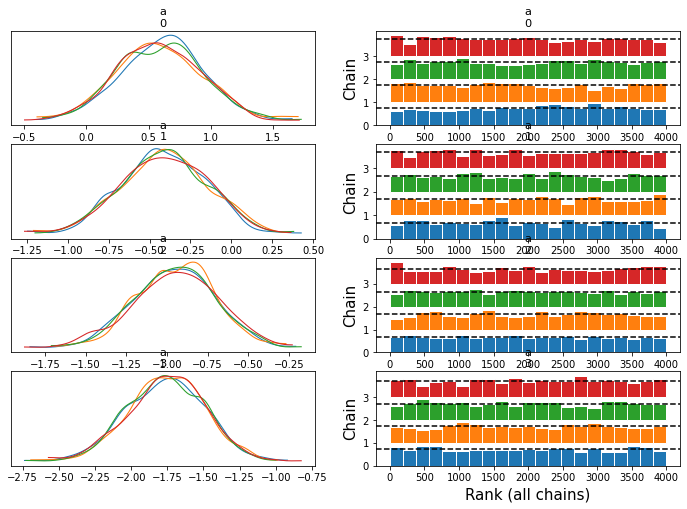

In [ ]:
az.plot_trace(trace_tot_eff, kind="rank_bars",compact = False)

Rank Bars and Plots of Trace plots show us small or slight discrepancies on all chains so we can say that chains that are produced indeed are good ones and can be relied on.

They also indicate that our priors are not bad but good ones for the Total Effect Model.

In [ ]:
correct_pred = pm.sample_posterior_predictive(trace_tot_eff, 200, tot_Eff)

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


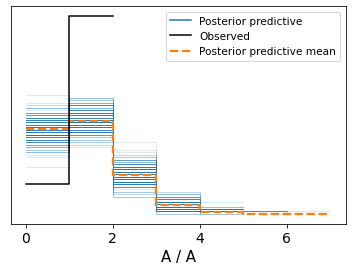

In [ ]:
az.plot_ppc(az.from_pymc3(posterior_predictive=correct_pred, model=tot_Eff))

Here one can see that from the posterior predictive mean plot of orange dashed lines for our Set_Size being 2 we get more correct and the correct percentage decreases with the Set_Size increases.

- What is the difference of probability of correct answer (contrast) between showing 6 and 2 items to the participants? (Simulate interventions for these two conditions with your posteriors, and show the contrast distribution using a suitable graph)

Here firstly we will set the set_size to 2 later on we will make them 6 and compare the effects on a plot.

In [ ]:
# your code here
from theano import shared
set_sizes = d_1.set_size.values
set_sizes_shared = shared(set_sizes)
set_2 = np.full(len(set_sizes),2)
set_sizes_shared.set_value(set_2)

In [ ]:
with tot_Eff:
    tot_Eff_2 = pm.sample_posterior_predictive(trace_tot_eff)

We did the set_size 2 now we will do it for set_size 6


In [ ]:
set_sizes_2 = d_1.set_size.values
set_sizes_shared_2 = shared(set_sizes_2)
set_6 = np.full(len(set_sizes_2),6)
set_sizes_shared_2.set_value(set_6)

In [ ]:
with tot_Eff:
    tot_Eff_6 = pm.sample_posterior_predictive(trace_tot_eff)

Here we will do the the difference plot.

Text(0, 0.5, 'density')

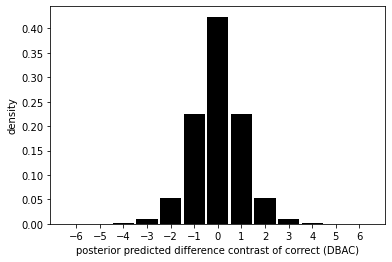

In [ ]:
ax = az.plot_dist(tot_Eff_2["A"] - tot_Eff_6["A"], color="k")
ax.set_xlabel("posterior predicted difference contrast of correct (DBAC)")
ax.set_ylabel("density")


I wanted to do a different plot, but only could came up with this one.

2. Estimate the **direct effect** of `set_size` on `correct` by following the Bayesian workflow. Describe how the posterior parameters should be interpreted(making suitable transformations when necessary)

Here we made our categoric model by using both tested and set_size as categories (which may be wrong but I assumed they looked like categories.)

And added them to logit function and made a binomial distribution for the correct values which also indicates categoric values.

In [ ]:
# your code here
with pm.Model() as tot_direct_Eff: 
    a = pm.Normal('a', 0, 1, shape = [4,8]) 
    p = pm.math.invlogit(a[d.did,d.gid]) 
    A = pm.Binomial('A', p = p, n = d_1.tested, observed = d_1.correct )  
    trace_dir_eff = pm.sample(1000, return_inferencedata=True)

# for direct effect T should be adjusted

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.


In [ ]:
az.summary(trace_dir_eff) 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"a[0, 0]",1.803,0.647,0.705,3.157,0.011,0.009,3748.0,1236.0,1.00
"a[0, 1]",-0.004,0.376,-0.696,0.698,0.005,0.010,5255.0,1479.0,1.00
"a[0, 2]",-0.015,0.971,-1.871,1.789,0.015,0.027,3928.0,1215.0,1.00
"a[0, 3]",0.005,1.017,-1.828,2.038,0.017,0.030,3785.0,1258.0,1.00
"a[0, 4]",-0.013,0.990,-1.830,1.991,0.017,0.029,3373.0,1228.0,1.00
"a[0, 5]",-0.013,1.006,-1.824,1.993,0.016,0.027,3749.0,1608.0,1.00
"a[0, 6]",0.013,0.985,-1.753,1.960,0.014,0.025,4830.0,1470.0,1.00
"a[0, 7]",0.004,1.014,-1.833,1.843,0.017,0.029,3609.0,1264.0,1.00
"a[1, 0]",1.351,0.681,0.110,2.613,0.011,0.010,3722.0,1507.0,1.00
"a[1, 1]",0.005,0.500,-0.859,0.993,0.007,0.013,5076.0,1406.0,1.00


It is important to note that some of these a values does not make sense since for a set_size of 6 cannot ask a test index of 7 or 8, so some of the samples that are taken from the system are not used and neglected.

Ess values gives us great effective sample size scores for each value both for tail and bulk so we can say these values are reliable

In [ ]:
az.summary(trace_dir_eff, kind="diagnostics")

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"a[0, 0]",0.011,0.009,3748.0,1236.0,1.00
"a[0, 1]",0.005,0.010,5255.0,1479.0,1.00
"a[0, 2]",0.015,0.027,3928.0,1215.0,1.00
"a[0, 3]",0.017,0.030,3785.0,1258.0,1.00
"a[0, 4]",0.017,0.029,3373.0,1228.0,1.00
"a[0, 5]",0.016,0.027,3749.0,1608.0,1.00
"a[0, 6]",0.014,0.025,4830.0,1470.0,1.00
"a[0, 7]",0.017,0.029,3609.0,1264.0,1.00
"a[1, 0]",0.011,0.010,3722.0,1507.0,1.00
"a[1, 1]",0.007,0.013,5076.0,1406.0,1.00


R_hat values and mmse values for all of the different test values and set_sizes are given. 

R_hat values are 1 which is great for all, that means values are converged and it also shows the convergence diagnostics that compares between and within chain estimates. So 1 as the score of Rhat will give us chains that are mixed well and between-within chain estimates agree. But if they were high that would not be the case.

Same also applies to MMSE scores.

/usr/local/lib/python3.7/dist-packages/arviz/plots/traceplot.py:216: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (32), generating only 20 plots
  UserWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f57a5849290>,
      dtype=object)

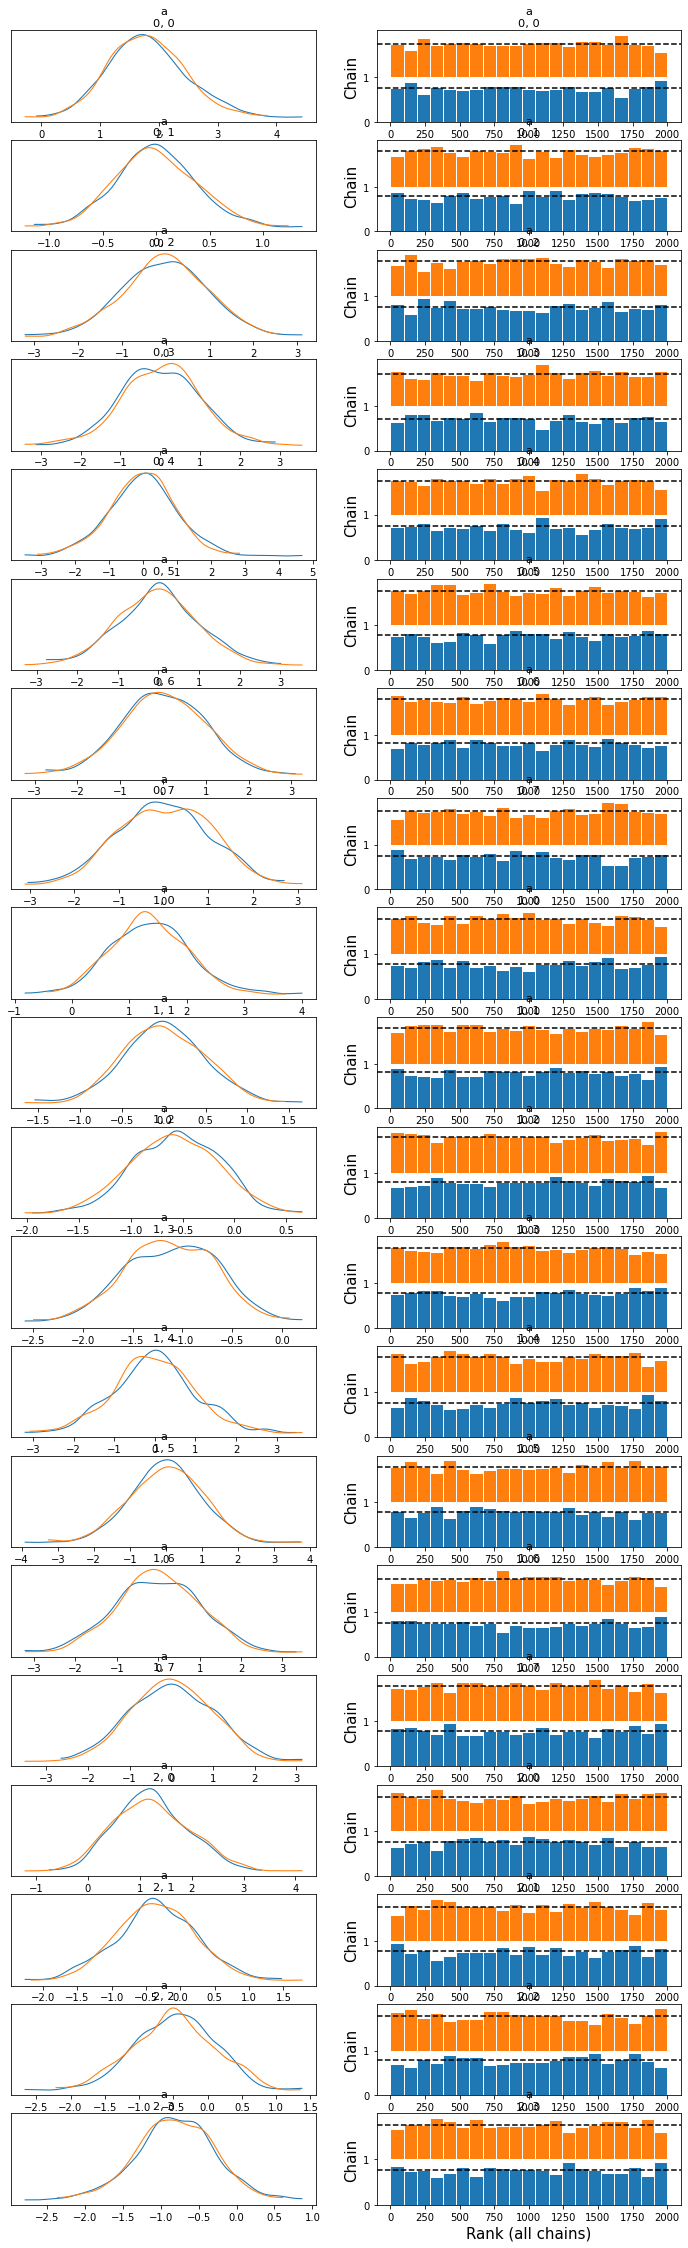

In [ ]:
az.plot_trace(trace_dir_eff, kind="rank_bars",compact = False)

Rank Bars and Plots of Trace plots show us small or slight discrepancies on all chains so we can say that chains that are produced indeed are good ones and can be relied on. 

They also indicate that our priors are not bad but good ones for the Direct Effect Model.

3. Compare the models you used for estimating the *total effect* and *direct effect* by using WAIC as your comparison measure. Discuss the predictive performance of these two models based on this.  

In [ ]:
# your code here

compare_dict = {"Direct":trace_dir_eff, "Total":trace_tot_eff}

In [ ]:
az.compare(compare_dict, ic ="waic")

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Direct,0,-71.398504,4.759623,0.000000,1.000000e+00,3.327018,0.000000,False,log
Total,1,-82.896880,1.762505,11.498376,5.329071e-14,3.098762,3.446501,False,log


# Comparison Analysis for WAIC


As from the comparison of the Direct effect model of the Set_size to Correct answer and also the Set_size to Tested to Correct answer which gives us the Total effect, indicates that Direct Effect model is a greater model. 

Since both models give warning False, we shouldn't worry about their results are misinterpreted, they are not. 

For negative-log scale which is what WAIC uses it indicates that smaller values of WAIC shows higher out-of-sample predictive fit or better model, so for that we can say that Direct Estimate is again better in absolute smaller value. 

p_waic => shows us the estimated effective number of parameters and Direct Effect model indicates higher n_eff so we can say that Direct is also better.

Weight shows us the relative weights of the models and it indicates that probability of the models and direct has a higher score on that. 

D_waic ==> shows us relative differences between the Direct and Total so since Direct is ranked the best, but their difference with total is 11.5 so it indicates they are distanced from each other as models for each estimate.

SE is the standard error and lower standard error is better but for the best one (Direct) for this question is higher.

Warning as mentioned above indicates computations of the information criterion can be mislead or unreliable, but for our testing both are reliable.

As the result ==> Direct Effect of Set_Size to Correct model is better for prediction then Total Effect


You may add more code or markdown blocks above between the questions as you see necessary.